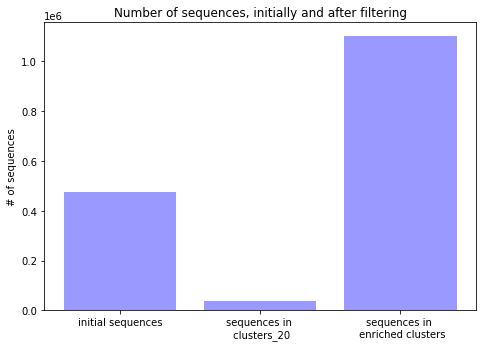

In [31]:
#create a nice diagram showing the proteins and clusters of the mcl algorithm output(clustering)
#the number of initial clusters and clusters>20 proteins
#initial clusters and clusters with >20 members
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

x_axis = ['initial sequences','sequences in \n clusters_20','sequences in \n enriched clusters']
proteins = [477002,37442,1102219]
plt.ylabel('# of sequences')
plt.title("Number of sequences, initially and after filtering")
ax.bar(x_axis,proteins,color='blue',alpha=0.4)
plt.savefig("seqs.png", bbox_inches='tight')


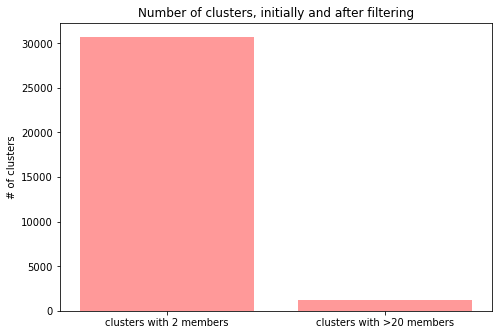

In [1]:
#initial proteins, proteins >20 and enriched proteins
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_axis = ['clusters with 2 members','clusters with >20 members']
clusters=[30748,1187]
plt.ylabel('# of clusters')
plt.title("Number of clusters, initially and after filtering")
ax.bar(x_axis,clusters,color='red',alpha=0.4)
plt.savefig("clusts.png",bbox_inches='tight')

In [2]:
import pandas as pd
import numpy as np
myfile=pd.read_csv("VIRAL_FAMILIES_20.txt",sep="\t",header=None)
def threshold_network(datafile=myfile,threshold=0.5, lineage_level='kingdom',newformat='updated_format.csv'):
    #remove the sequence, since we do not need it in that case
    datafile=datafile.drop(columns=3)
    #give specific names to the columns
    datafile=datafile.rename(columns={0:'cluster_family',1:'protein_member',2:'lineage'})
    lin=datafile[['cluster_family','lineage']]
    lin=lin.replace(';', ' ', regex=True)
    # Extract every taxon from the string  
    lin['realm'] = lin['lineage'].str.extract('(\w*viria)', expand=True) 
    lin['kingdom'] = lin['lineage'].str.extract('(\w*virae)', expand=True) 
    lin['phylum'] = lin['lineage'].str.extract('(\w*viricota)', expand=True) 
    lin['clas'] = lin['lineage'].str.extract('(\w*viricetes)', expand=True) 
    lin['order'] = lin['lineage'].str.extract('(\w*virales)', expand=True) 
    lin['family'] = lin['lineage'].str.extract('(\w*viridae)', expand=True) 
    lin['subfamily'] = lin['lineage'].str.extract('(\w*virinae)', expand=True) 
    lin['genus'] = lin['lineage'].str.extract('(\w*virus\s)', expand=True) 
    #seperate dataframe by family groups
    groups=lin.groupby('cluster_family')[lineage_level].apply(list).reset_index()
    lin=lin.drop(columns=['lineage'])
    lin.to_csv(newformat, index=False,sep='\t')
    rows=len(groups.index)
    for x in range(0,rows):
        list_=groups[lineage_level][x]
        most_freq=[]
        for y in list_:
            per=list_.count(y)/len(list_)
            if y not in most_freq:
                if per>=threshold:
                    most_freq.append(y)
        #update the dataframe
        groups[lineage_level][x]=most_freq
        
        lens = [len(item) for item in groups[lineage_level]]
        network=pd.DataFrame( {"cluster_family" : np.repeat(groups['cluster_family'].values,lens), 
                          "lineage_level" : np.concatenate(groups[lineage_level].values)})
    #output the most frequent taxon by family
    #network=groups.agg(pd.Series.mode).to_frame()
    
    return network



In [3]:

#find the unique taxonomic lineage levels in families(>20 members) that exist before enrichment
levels=['realm','kingdom','phylum','clas','order','family','subfamily','genus']
network=[None]*8
for i in range(len(levels)):
    network[i]=threshold_network(myfile,lineage_level=levels[i],threshold=0.05)
network[0]


/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,cluster_family,lineage_level
0,1,Monodnaviria
1,2,Monodnaviria
2,3,Monodnaviria
3,4,Monodnaviria
4,5,Monodnaviria
...,...,...
1186,1183,Duplodnaviria
1187,1184,Duplodnaviria
1188,1185,Duplodnaviria
1189,1186,Duplodnaviria


In [4]:
for i in range(len(levels)):
    #length of unique taxnomic labels
    length=len(network[i]['lineage_level'].unique().tolist())
    print(length)

5
5
6
7
8
17
32
208


In [ ]:
#print the new labels only when there is difference before and after the enrichment
levels2=['order','family','subfamily','genus']
#labels are the lists before the enrichment
labels=['None']*4
#en_labels are the lists after the enrichment
en_labels=['None']*4

for i in range(len(levels2)):
    #length of unique taxnomic labels
    labels[i]=(network[i+4]['lineage_level'].unique().tolist())
#import the lists after the enrichment
for i in range(len(levels2)):
    with open('en_list%d.txt' %i,'r') as f:
        en_labels[i]=f.read().splitlines()

#compare and extract the differences
diff=['None']*4
for i in range(len(levels2)):
    s=labels[i]
    diff[i]=[x for x in en_labels[i] if x not in s]
diff[3]

In [31]:
len(en_labels[3])

238

In [15]:
from itertools import combinations 

#make a function that will transform a network(csv to pandas) into an adjacency matrix/ network input is in the type of a pandas df
def net2am(network):
    #replace taxid level column with 'source' and family member column with 'target' 
    network=network.rename(columns={0:"source",1:'target'})
    #fill nan values of taxid levels with zeros
    network['source']=network['source'].fillna(0)
    #create a list of how many family members are connected only to one taxid level
    #/ to fill the diagonal of the matrix
    fam_mems=network['source'].value_counts(sort=False,ascending=False,dropna=False).to_list()
    #create a list of unique taxid levels 
    #/ to be the rows and columns of the adj matrix(am)
    taxids=network['source'].value_counts(sort=False,ascending=False,dropna=False).index.to_list()
    #create the layout of the am
    am = pd.DataFrame(np.zeros(shape=(len(taxids),len(taxids))), columns=taxids, index=taxids)
    np.fill_diagonal(am.values, fam_mems)
    #create a list of 'target' that will show the connections of the network
    #store the double connections in the dubl list
    list1=network['target'].to_list()
    ten, nine, eight, sev,six,fiv,four,thr,two = ([] for i in range(9))
    
    for i in range(1,len(list1)+1):
        if list1.count(i)==10:
            ten.append(i)
            continue
        if list1.count(i)==9:
            nine.append(i)
            continue
        if list1.count(i)==8:
            eight.append(i)
            continue
        if list1.count(i)==7:
            sev.append(i)
            continue
        if list1.count(i)==6:
            six.append(i)
            continue
        if list1.count(i)==5:
            fiv.append(i)
            continue
        if list1.count(i)==4:
            four.append(i)
            continue
        if list1.count(i)==3:
            thr.append(i)
            continue
        if list1.count(i)==2:
            two.append(i)
            continue
    #for all the connections append in the adjacency matrix
    #kanto me ton paradosiako tropo
    for listt in ten, nine, eight,sev,six,fiv,four,thr,two:
        for connection in listt:
            cel=network[network['target']==connection]['source'].to_list()
            for combo in combinations(cel, 2):  # 2 for pairs
                am.at[combo[0],combo[1]]+=1
                #make the matrix symmetric
                am.at[combo[1],combo[0]]+=1

    #show the final adjacency matrix, hurrayy
    return am
   

In [16]:
a=net2am(network_genus)
a

,0,Wizardvirus,Lederbergvirus,Chenonavirus,Elunavirus,Bastillevirus,Karamvirus,Drulisvirus,Pbunavirus,Teseptimavirus,...,Tritonvirus,Vespertilionpoxvirus,Radnorvirus,Ashivirus,Vequintavirus,Caroctavirus,Beetrevirus,Buttersvirus,Neptunevirus,Felixounavirus
0,232.0,1.0,8.0,1.0,0.0,4.0,22.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,65.0,1.0
Wizardvirus,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lederbergvirus,8.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chenonavirus,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Elunavirus,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Caroctavirus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
Beetrevirus,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
Buttersvirus,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Neptunevirus,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,0.0


In [17]:
a=net2am(network_genus)
a

,0,Wizardvirus,Lederbergvirus,Chenonavirus,Elunavirus,Bastillevirus,Karamvirus,Drulisvirus,Pbunavirus,Teseptimavirus,...,Tritonvirus,Vespertilionpoxvirus,Radnorvirus,Ashivirus,Vequintavirus,Caroctavirus,Beetrevirus,Buttersvirus,Neptunevirus,Felixounavirus
0,232.0,1.0,8.0,1.0,0.0,4.0,22.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,65.0,1.0
Wizardvirus,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lederbergvirus,8.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chenonavirus,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Elunavirus,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Caroctavirus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
Beetrevirus,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
Buttersvirus,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Neptunevirus,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,0.0


In [20]:
b=net2am(network_family)
b

,0,Marseilleviridae,Iridoviridae,Podoviridae,Siphoviridae,Geminiviridae,Baculoviridae,Poxviridae,Phycodnaviridae,Drexlerviridae,Demerecviridae,Ackermannviridae,Myoviridae,Adenoviridae,Autographiviridae,Potyviridae,Herelleviridae
0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Marseilleviridae,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Iridoviridae,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Podoviridae,0.0,0.0,0.0,21.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
Siphoviridae,2.0,0.0,0.0,18.0,401.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0
Geminiviridae,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Baculoviridae,0.0,1.0,0.0,0.0,0.0,0.0,13.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Poxviridae,0.0,1.0,0.0,0.0,0.0,0.0,2.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Phycodnaviridae,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Drexlerviridae,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
c=net2am(network_kingdom)
c

,0,Bamfordvirae,Orthornavirae,Heunggongvirae,Shotokuvirae
0,17.0,2.0,0.0,2.0,0.0
Bamfordvirae,2.0,32.0,0.0,0.0,0.0
Orthornavirae,0.0,0.0,1.0,0.0,0.0
Heunggongvirae,2.0,0.0,0.0,1111.0,0.0
Shotokuvirae,0.0,0.0,0.0,0.0,30.0


In [32]:
d=net2am(network_phylum)
d

,0,Uroviricota,Nucleocytoviricota,Preplasmiviricota,Pisuviricota,Cressdnaviricota
0,17.0,2.0,2.0,0.0,0.0,0.0
Uroviricota,2.0,1111.0,0.0,0.0,0.0,0.0
Nucleocytoviricota,2.0,0.0,20.0,0.0,0.0,0.0
Preplasmiviricota,0.0,0.0,0.0,12.0,0.0,0.0
Pisuviricota,0.0,0.0,0.0,0.0,1.0,0.0
Cressdnaviricota,0.0,0.0,0.0,0.0,0.0,30.0


In [33]:
e=net2am(network_class)
e

,0,Pokkesviricetes,Megaviricetes,Caudoviricetes,Repensiviricetes,Stelpaviricetes,Tectiliviricetes
0,17.0,2.0,1.0,2.0,0.0,0.0,0.0
Pokkesviricetes,2.0,19.0,1.0,0.0,0.0,0.0,0.0
Megaviricetes,1.0,1.0,2.0,0.0,0.0,0.0,0.0
Caudoviricetes,2.0,0.0,0.0,1111.0,0.0,0.0,0.0
Repensiviricetes,0.0,0.0,0.0,0.0,30.0,0.0,0.0
Stelpaviricetes,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Tectiliviricetes,0.0,0.0,0.0,0.0,0.0,0.0,12.0


In [34]:
f=net2am(network_order)
f

,0,Pimascovirales,Geplafuvirales,Rowavirales,Algavirales,Chitovirales,Patatavirales,Caudovirales
0,17.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0
Pimascovirales,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0
Geplafuvirales,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
Rowavirales,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0
Algavirales,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
Chitovirales,2.0,1.0,0.0,0.0,1.0,19.0,0.0,0.0
Patatavirales,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Caudovirales,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1111.0


In [ ]:
## filter initial sequences ang get only clusters with 2 members 
#also get clusters that stand alone(no connections)

